# Session 5 (Bonus): Implementing a simple Eco-Evolutionary simulation

In all precedent sessions, we saw how to control simulation from notebook by modifying agents behaviors, manipulating their sensors, their diets ... how to make resources spawn, assign species to agents ......, attach routines ...

Now we are going to see how we can combine all these features to implement a simple Eco-Evolutionary simulation ! 

An eco-evolutionary simulation is a virtual environment where small agents (like robots) interact with each other and their surroundings. Over time, these agents adapt and evolve based on environmental challenges and competition for resources. The simulation models both ecological processes (like food gathering or predator-prey relationships) and evolutionary changes (like traits being passed down to future generations).

In [1]:
import numpy as np

from vivarium.controllers.notebook_controller import NotebookController
from vivarium.utils.handle_server_interface import start_server_and_interface, stop_server_and_interface

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
start_server_and_interface(scene_name="session_5")

/home/cleger/Desktop/code/vivarium/vivarium/utils
STARTING SERVER


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[2024-11-25 14:48:18,993][__main__][INFO] - Scene running: session_5
[2024-11-25 14:48:21,668][vivarium.simulator.simulator][INFO] - Simulator initialized

STARTING INTERFACE


2024-11-25 14:48:23,580 Starting Bokeh server version 3.3.4 (running on Tornado 6.4)
2024-11-25 14:48:23,580 User authentication hooks NOT provided (default user enabled)
2024-11-25 14:48:23,582 Bokeh app running at: http://localhost:5006/run_interface
2024-11-25 14:48:23,582 Starting Bokeh server with process id: 33727
2024-11-25 14:48:36,107 An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-11-25 14:48:38,248 WebSocket connection opened
2024-11-25 14:48:38,298 ServerConnection created


Start running the controller and check the subtypes of this session

In [3]:
controller = NotebookController()

/home/cleger/Desktop/code/vivarium/venv/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [4]:
controller.run()

In [5]:
controller.agents[0].left_motor = 0.5
controller.print_subtypes_list()

['s_obstacles', 'b_obstacles', 'resources', 'robots']


define behaviors in advance like in the precedent notebook

In [6]:
def fear(robot):
    left, right = robot.sensors(sensed_entities=["robots"])
    left_wheel = left
    right_wheel = right
    return left_wheel, right_wheel

def aggression(robot):
    left, right = robot.sensors(sensed_entities=["robots"])
    left_wheel = right
    right_wheel = left
    return left_wheel, right_wheel

def love_cuddly(robot):
    left, right = robot.sensors(sensed_entities=["robots"])
    left_wheel = 1 - left
    right_wheel = 1 - right   
    return left_wheel, right_wheel

def love_shy(robot):
    left, right = robot.sensors(sensed_entities=["robots"])
    left_wheel = 1 - right
    right_wheel = 1 - left   
    return left_wheel, right_wheel

def obstacle_avoidance(robot):
    left, right = robot.sensors(sensed_entities=["s_obstacles", "b_obstacles"])
    left_wheel = 1 - right
    right_wheel = 1 - left   
    return left_wheel, right_wheel

## 1 - Understanding alive and dead agents

In [7]:
n_agents = len(controller.agents)
print(f"Number of agents: {n_agents}")

Number of agents: 10


We can see there are only 4 agents in the simulator. 10 is the max number of agents. We can check this with the following command and see which agents are dead or alive :

In [8]:
for agent in controller.agents:
    print(f"agent {agent.idx}: exists = {agent.exists}")

agent 0: exists = True
agent 1: exists = True
agent 2: exists = True
agent 3: exists = True
agent 4: exists = False
agent 5: exists = False
agent 6: exists = False
agent 7: exists = False
agent 8: exists = False
agent 9: exists = False


First 4 agents of the simulator are alive ... Now we are going to see how to make an agent spawn and die:

In [9]:
agent_idx = 4 # idx of a dead agent
agent = controller.agents[agent_idx]
agent.exists = True # make the agent spawn

we can also do it with the spawn_entity function of the controller :

In [10]:
agent_idx = 5 # idx of a dead agent
controller.spawn_entity(agent_idx)

Now let's see how to kill an agent :

In [11]:
agent_idx = 4 # idx of an alive agent
agent = controller.agents[agent_idx]
agent.exists = False # kill the agent

And again we have a method in the controller to do that : remove_entity

In [12]:
agent_idx = 5 # idx of an alive agent
controller.remove_entity(agent_idx)

Entity 5 already removed


Now you have the basics to make agents spwan and die ! 

Let's see how to manipulate dead and alive agents lists now, you can either get these lists manually:

In [15]:
print("Getting existing agents manually: ")
for agent in controller.agents:
    if agent.exists == True:
        print(agent.idx)

Getting existing agents manually: 
0
1
2
3


But you also have helper attributes to do that :

In [16]:
print("Getting existing agents with an attribute: ")
for agent in controller.existing_agents:
    print(agent.idx)

print("\nGetting non existing agents with an attribute: ")
for agent in controller.non_existing_agents:
    print(agent.idx)

Getting existing agents with an attribute: 
0
1
2
3

Getting non existing agents with an attribute: 
4
5
6
7
8
9


Attach behaviors to existing agents (you can technically also attach them to dead agents but it won't have any effect):

In [12]:
for agent in controller.agents:
    if agent.exists == True:
        agent.attach_behavior(obstacle_avoidance)
        agent.attach_behavior(love_cuddly)
        agent.start_all_behaviors()

In [13]:
for agent in controller.agents:
    agent.print_behaviors()

Available behaviors: ['obstacle_avoidance', 'love_cuddly'], Active behaviors: ['obstacle_avoidance', 'love_cuddly']
Available behaviors: ['obstacle_avoidance', 'love_cuddly'], Active behaviors: ['obstacle_avoidance', 'love_cuddly']
Available behaviors: ['obstacle_avoidance', 'love_cuddly'], Active behaviors: ['obstacle_avoidance', 'love_cuddly']
Available behaviors: ['obstacle_avoidance', 'love_cuddly'], Active behaviors: ['obstacle_avoidance', 'love_cuddly']
No behaviors attached
No behaviors attached
No behaviors attached
No behaviors attached
No behaviors attached
No behaviors attached


In [14]:
for agent in controller.agents:
    agent.detach_all_behaviors(stop_motors=True)

## Comment : Funny emergent behavior

Could add this in a session, agents start behavior like a kind of spine and follow each other while detecting themselves at max range --> very like life phenomenon liek a kind of snake

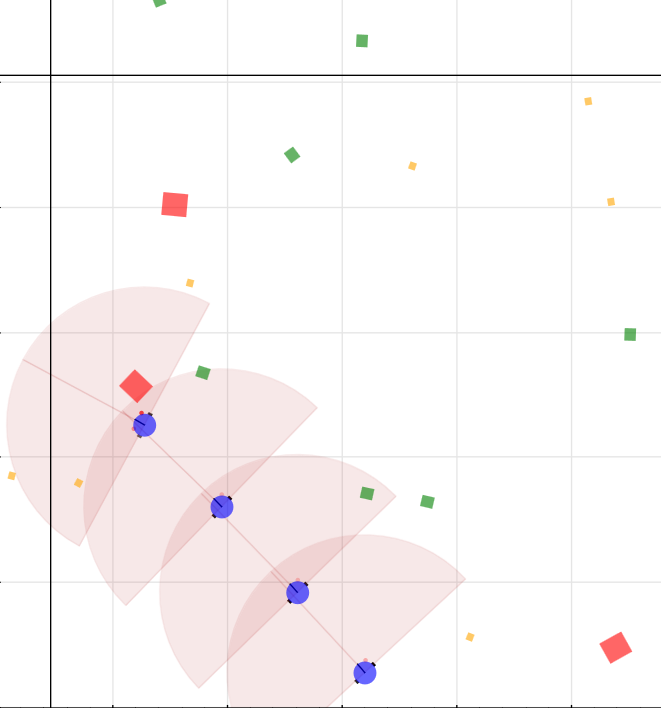

And actually seems to last forever with the current configutation ! even with obstacles on the side


Start object apparition and make agents eat them

## 2 - Understanding Entities routines

We already saw little agents routines ... e.g for eating behaviors, lets see other examples

### Making an object move

You can easielty make an object move with the following routine (e.g move to the left by 2. units every step):

In [15]:
position_shift = 2.

def move_entity_left_routine(entity):
    entity.x_position += position_shift

def move_entity_top_routine(entity):
    entity.y_position += position_shift

In [16]:
obj = controller.objects[0]
obj.diameter = 10.
obj.color = "black"

you can set the interval how you want

In [17]:
obj.attach_routine(move_entity_left_routine, interval=1)

You can combine this with a routine to go top, which will make object move diagonally

In [18]:
obj.attach_routine(move_entity_top_routine, interval=1)

detach the routines for the object : 

In [19]:
obj.detach_routine("move_entity_left_routine")
obj.detach_routine("move_entity_top_routine")

Actually, this would work on any kind of entity like agents, so can do it like that :

In [ ]:
ag = controller.agents[0]

ag.attach_routine(move_entity_left_routine, interval=1)
ag.attach_routine(move_entity_top_routine, interval=1)

In [24]:
ag.detach_routine("move_entity_left_routine")
ag.detach_routine("move_entity_top_routine")

### Making an entity change color periodically :

First, better understand how colors work in the controller. Actually you can pass them as strings but they are represented in hex format :

In [25]:
agent_color = ag.color
print(f"Agent color is: {agent_color}")

Agent color is: #0000ff


Example of how this works :

In [26]:
import matplotlib.colors as colors

# blue color
print("Blue color")
print(f"Transforming blue text color to hex: {colors.to_hex('blue')}")
print(f"Transforming blue rgb color to hex: {colors.to_hex((0.0, 0.0, 1.0))}")

# red color
print("\nRed color")
print(f"Transforming red text color to RGB: {colors.to_rgb('red')}")
print(f"Transforming red rgb color to RGB: {colors.to_rgb('#ff0000')}")

Blue color
Transforming blue text color to hex: #0000ff
Transforming blue rgb color to hex: #0000ff

Red color
Transforming red text color to RGB: (1.0, 0.0, 0.0)
Transforming red rgb color to RGB: (1.0, 0.0, 0.0)


Now that you know how to get the hex code of a color, you can also make an entity change color periodically with the following routine :

In [27]:
def change_color(entity):
    if entity.color == colors.to_hex("blue"):
        entity.color = "cyan"
    else:
        entity.color = "blue"

In [28]:
ag.attach_routine(change_color, interval=5)

You can run the following cell several times to see the color change

In [29]:
ag.color

'#00ffff'

In [30]:
ag.detach_routine("change_color")

This isn't particularly useful but it's a good example of how you can manipulate entities in the simulation. You can also combine this with other routines to create more complex behaviors. For example, we could have this kind of routines attached to agents to indicate their health status (blinking when they have low energy ...).

## 2 - Understanding Controller routines

We already saw little agents routines ... e.g for eating behaviors, lets see other examples

As for entities, the notebook controller can also have routines. An example of this is the spawn ressources function you already saw ! Under the hood, it is implemented as a routine : 

# TODO : can see how we handle that and maybe remove doc, asserts ... 

In [ ]:
# TODO : just do this for the resources and remove position range, entity type ... --> will make the code way simpler
def spawn_entity_routine_fn(controller, entity_type=None, position_range=None):
    """Spawn entities of type entity_type every period seconds within a given position range

    :param period: period
    :param entity_type: entity_type, defaults to None
    :param position_range: position_range, defaults to None
    """
    assert entity_type is not None, "Please specify the entity type"
    assert isinstance(entity_type, int), "Entity type must be an integer index"

    # transform the position range if not specified
    if position_range is None:
        position_range = ((0, controller.box_size), (0, controller.box_size)) 

    non_existing_ent_list = [ent.idx for ent in controller.all_entities if not ent.exists and ent.subtype == entity_type]
    if non_existing_ent_list:
        ent_idx = np.random.choice(non_existing_ent_list)
        x = np.random.uniform(position_range[0][0], position_range[0][1], 1)
        y = np.random.uniform(position_range[1][0], position_range[1][1], 1)
        controller.spawn_entity(ent_idx, position=(x, y))
    else:
        print(f'All entities of type {entity_type} are spawned')


# TODO : might kind of complex to show them how the thing works under the hood here (functions in the NotebookController class):
# TODO : Can recreate a simplified version of the mechanism with 1 single function --> easier to present etc.
#   def start_entity_apparition(self, interval=50, entity_type: str = None, position_range=None):
#         """Start the apparition process for entities of type entity_type every period seconds

#         :param period: period, defaults to 5
#         :param entity_type: entity_type, defaults to None
#         :param position_range: position range where entities can spawn, defaults to None
#         """
#         entity_type_idx = self.get_idx_from_label_subtype(entity_type)

#         routine_fn = functools.partial(spawn_entity_routine_fn, entity_type=entity_type_idx, position_range=position_range)
#         # add the name of the spawning routine function otherwise error in the routine handler
#         self.attach_routine(routine_fn, name=spawn_entity_routine_fn.__name__, interval=interval)

#     def start_resources_apparition(self, interval=50, position_range=None):
#         """Start the resources apparition process

#         :param period: period, defaults to 5
#         :param position_range: position_range, defaults to None
#         """
#         resources_type = "resources"
#         self.start_entity_apparition(interval, entity_type=resources_type, position_range=position_range)
#         # start the eating routine for agents
#         self.attach_routine(eating_routine_fn)

This is really useful to make the simulation evolve over time. For example, ...

Let's see how we can implement a reproduction routine for agents thanks to this ! First, do something to give them energy levels, make them eat ... Then based on these previous conditions we can make them reproduce :

Because we have a max number of agents, to make new ones spawn, we have to get the idx of the dead agents.

In [32]:
dead_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]
print(dead_agents_idx)

[4, 5, 6, 7, 8, 9]


then, to pick a random idx inside the list of dead agents, use the numpy random choice function : (note that if you execute the function several times, you will see that the idx is different each time)

In [33]:
agent_idx = np.random.choice(dead_agents_idx)
print(agent_idx)

9


To make agents spawn at the same position as their parents, we have to implement little tricks. Let's say the agent 0 will reproduce, we can get its position with the following command :

In [34]:
agent_idx = 0
# get agent position
position = [agent.x_position, agent.y_position]
print(f"position = {position}")

position = [17.2849063873291, 6.892883777618408]


If we want to prevent collision errors, we need to spawn the new agent with a position that is slightly different from parent pos. To do so, we can add a little random epsilon to the modify the position of the offspring with numpy:

In [38]:
# epsilon between -max_distance and +max_distance, of shape (2)
max_distance = 5
epsilon = np.random.uniform(-max_distance, max_distance, 2)
print(f"epsilon = {epsilon}")

# create new position by adding epsilon to the current position
new_position = position + epsilon
print(f"new_position = {new_position}")

epsilon = [2.05817292 0.17115042]
new_position = [19.34307931  7.06403419]


## 2.1 - Implementing an asexual reproduction routine

We also previously saw how to spawn entities with the controller. Now with all this information we can implement a simple reproduction routine for agents ! 

In [39]:
def foraging(robot):
    left, right = robot.sensors(sensed_entities=["resources"])
    left_activation = right
    right_activation = left
    return left_activation, right_activation

In [80]:
# spawn the a new agent every time an agent has eaten !
offspring_diameter = 7.

def asexual_reproduction(controller):
    # iterate over all agents in the controller
    for robot in controller.agents: 
        # check if the robot has eaten and if it is alive
        if robot.exists and robot.has_eaten():
            # get the index of the dead agents to select one and make it spawn
            dead_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]
            # check if there are dead agents (if dead_agents_idx an empty list, do nothing)
            if dead_agents_idx:
                # if there are dead agents, select one randomly
                agent_idx = np.random.choice(dead_agents_idx)
                # add some noise to the position of the parent
                epsilon = np.random.uniform(-max_distance, max_distance, 2)
                position = [robot.x_position, robot.y_position]
                new_position = position + epsilon
                # give the new position to the spawn entity
                offspring = controller.spawn_entity(agent_idx, position=new_position) 
                offspring.diameter = offspring_diameter
                offspring.attach_behavior(obstacle_avoidance)
                offspring.attach_behavior(foraging)
                offspring.start_all_behaviors()
            else:
                pass

Indeed problem if do a typo on en entity subtype, so enum could indeed be a good choice here idk.

In [41]:
for agent in controller.agents:
    agent.diet = ["resources"]
    agent.detach_behavior("love_cuddly")
    agent.attach_behavior(obstacle_avoidance)
    agent.attach_behavior(foraging)
    agent.start_all_behaviors()

In [52]:
controller.print_fps()

measuring the FPS (number of steps per second) in the controller during 2 seconds


FPS: 5.50


extremely slow on my Windows Machine and a lot of entities / routines.

Choose a spwaning interval according to fps of the simulator.

In [51]:
for agent in controller.agents:
    agent.ate = False

controller.start_resources_apparition(interval=30)

In [53]:
# have to put interval = 1 otherwise the has eaten function won't work
controller.attach_routine(asexual_reproduction, interval=1)

In [61]:
controller.detach_all_routines()

for entity in controller.all_entities:
    entity.detach_all_routines()
    if entity.subtype_label == "robots":
        entity.detach_all_behaviors(stop_motors=True)

## 2.1 - Add sexual reproduction with a controller routine

Nice, now we have agents that can spawn offsprings next to them when they eat ! We could also think of other types of reproduction, for example if two agents are close to each other, they can reproduce. We can implement this with a simple controller routine.

First, stop all the agents and remove their current behaviors and routines.

In [70]:
for idx in range(5, n_agents):
    controller.remove_entity(idx)

Entity 5 already removed
Entity 6 already removed
Entity 8 already removed
Entity 9 already removed


In [71]:
for agent in controller.agents:
    agent.can_reproduce = True

In [81]:
reproduction_range = 30.

def sexual_reproduction(controller):
    for agent in controller.agents:
        # skip to next agent if the agent does not exist
        if not agent.exists:
            continue

        # get the index of the other existing agents
        other_existing_agents_idx = [ent.idx for ent in controller.agents if ent.exists == True and ent.idx != agent.idx]
        distances = agent.config.proximity_map_dist[other_existing_agents_idx]
        in_range = distances < reproduction_range
        found_mate = np.any(in_range)
        
        # need to eat a ressource and find a mate to reproduce
        if found_mate and agent.can_reproduce:
            # copy the code of the spawn_offspring_v1 routine
            # TODO : see if we copy all this or if we can encapsulate it in a function (but idk if students will be comfortable with functions)
            dead_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]
            if dead_agents_idx:
                agent_idx = np.random.choice(dead_agents_idx)
                # add some noise to the position
                epsilon = np.random.uniform(-max_distance, max_distance, 2)
                position = [agent.x_position, agent.y_position]
                new_position = position + epsilon
                # give the new position to the spawn entity
                offspring = controller.spawn_entity(agent_idx, position=new_position) 
                offspring.diameter = offspring_diameter
                offspring.attach_behavior(obstacle_avoidance)
                offspring.attach_behavior(foraging)
                offspring.start_all_behaviors()
                # pretty funny to remove this line, does a kind of explosion of spawning agents
                offspring.can_reproduce = False
                agent.can_reproduce = False
            else:
                pass

Then could do a system where agents can reproduce again if they have eaten again ... Or something else and add this to agents as routines. Could also imagine something where offsprings grow when they eat and become bigger / can also reproduce ... --> To implement for students

In [72]:
controller.print_fps()

measuring the FPS (number of steps per second) in the controller during 2 seconds


FPS: 6.00


In [84]:
controller.attach_routine(sexual_reproduction)
controller.start_resources_apparition(interval=30)

In [69]:
for agent in controller.agents:
    agent.ate = False
    agent.detach_all_behaviors(stop_motors=True)
    agent.attach_behavior(obstacle_avoidance)
    # add aggression behavior so agents go towards each other
    agent.attach_behavior(aggression)
    agent.attach_behavior(foraging)
    agent.start_all_behaviors()

## Make agents eat each other

### TODO --> Problem with the diet attribute of the agents (preds also eat preds)
### TODO --> Introducing different subtypes of agents would be the easiest solution, else implement custom routines

We would like to put predator agents that can eat prey agents. We can't currently do this by using the diet attribute of the agent. Because it would mean that prey will eat other preys also. At the moment just replace the classic eating mechanism with a new function that also takes into account the species of the agent (e.g put 5 agents preds and 5 preys). Cannot manipulate the subtype or otherwise it will break things on the server side. Juste rewrite the function.

Or we can predefine the classes preys and predators ! See what seems to be the best / cleanest solution. 


We can make agents eat each other by simply using the diet attribute of the agent ! Let's create prey and predator agents and add preys in the diet of predators.

In [39]:
for agent in controller.agents:
    agent.exists = True
    agent.detach_all_behaviors(stop_motors=True)
    agent.detach_all_routines()
    agent.attach_behavior(obstacle_avoidance)

In [40]:
controller.detach_routine("agents_reproduction")

In [85]:
def fear_pred(robot):
    (left, right) = robot.sensors(sensed_entities=["robots"])
    left_species, right_species = robot.sense_attributes(sensed_attribute="species", default_value ="none")
    left_activation = left if left_species == "pred" else 0
    right_activation = right if right_species == "pred" else 0
    return left_activation, right_activation

def aggr_preys(robot):
    (left, right) = robot.sensors(sensed_entities=["robots"])
    left_species, right_species = robot.sense_attributes(sensed_attribute="species", default_value ="none")
    # left_activation = left if left_species == "pred" else 0
    # right_activation = right if right_species == "pred" else 0
    right_activation = left if left_species == "prey" else 0
    left_activation = right if right_species == "prey" else 0
    return left_activation, right_activation

In [86]:
half_agents = n_agents // 2

for agent in controller.agents[:half_agents]:
    agent.species = "pred"
    agent.color = "red"
    agent.diameter = 12.
    agent.wheel_diameter = 4.
    agent.diet = ["robots"]
    agent.eating_range = 20.
    agent.attach_behavior(fear_pred)
    agent.attach_behavior(aggr_preys)

for agent in controller.agents[half_agents:]:
    agent.species = "prey"
    agent.color = "cyan"
    agent.diameter = 10.
    agent.wheel_diameter = 4.
    agent.diet = ["robots"]
    agent.attach_behavior(fear_pred)
    agent.attach_behavior(foraging)

In [88]:
for agent in controller.agents:
    agent.start_all_behaviors()
    agent.print_behaviors()

Available behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidanc

Can be improved but first step, to see if prevent predators from eating each other because results in a scene with only 1 predator : 

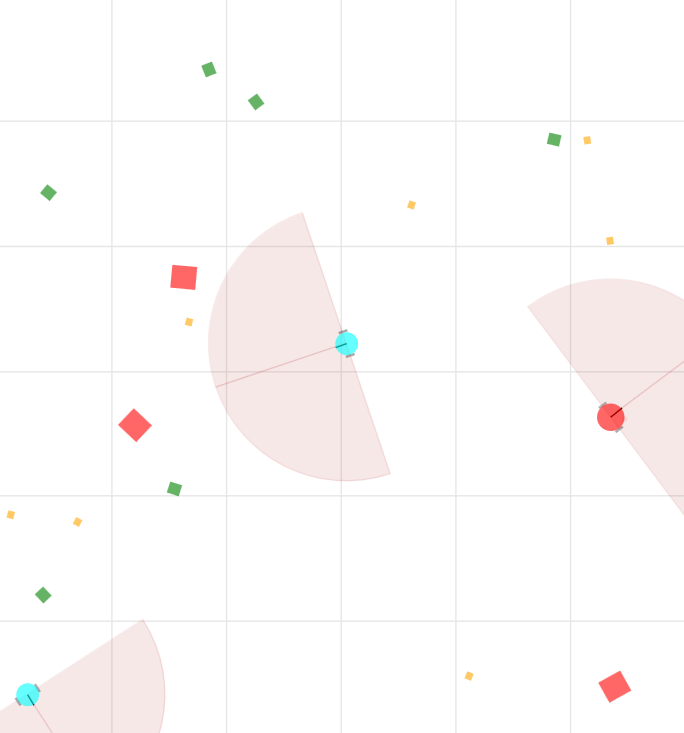

In [45]:
stop_server_and_interface()
controller.stop()

Received signal 15, shutting down
Server and Interface Stopped
